In [156]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from survae import SurVAE, DEVICE
from survae.data import MNIST_784
from survae.layer import *
from survae.calibrate import *

import json

In [2]:
mnist_dataset = MNIST_784()

In [3]:
sv_maxpool = SurVAE(
    # [DequantizationLayer()] + # the dequantization layer makes the reconstruction error pretty pointless in practice
    [
        [BijectiveLayer(784, [200, 200]), OrthonormalLayer(784)] # 784 = 28^2
        for _ in range(5)
    ] +
    [MaxPoolingLayer(784, 2, learn_distribution_parameter=True)] + 
    [
        [BijectiveLayer(196, [200, 200]), OrthonormalLayer(196)] # 196 = 14^2
        for _ in range(5)
    ] +
    [MaxPoolingLayer(196, 2, learn_distribution_parameter=True)] +
    [
        [BijectiveLayer(49, [200, 200]), OrthonormalLayer(49)] # 49 = 7^2
        for _ in range(5)
    ] +
    [MaxPoolingLayerWithHop(49, 3, 2, learn_distribution_parameter=True)] +
    [
        [BijectiveLayer(9, [200, 200]), OrthonormalLayer(9)] # 9 = 3^2
        for _ in range(5)
    ],
    name = "SV_MAXPOOL",
    condition_size = 10,
)

In [4]:
log = sv_maxpool.train(
    dataset    = mnist_dataset,
    batch_size = 1000,
    test_size  = 100,
    epochs     = 40_000,
    lr         = 5e-3,
    log_period = 100,
    show_tqdm  = True,
    reconstruction_loss_weight = 0.01,
    lr_decay_params = {'gamma': 0.95, 'step_size': 500},
    save_path = './saves/sv_maxpool overnight',
)

100%|██████████| 40000/40000 [6:48:59<00:00,  1.63it/s]  


In [5]:
times = list(log.keys())
loss_train = [m.training_loss for m in log.values()]
loss_test = [m.testing_loss for m in log.values()]
# print(loss_train)

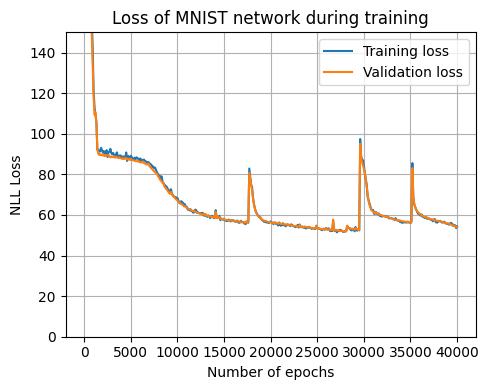

In [167]:
plt.figure(figsize=(5, 4))

plt.plot(times, loss_train, label='Training loss')
plt.plot(times, loss_test, label='Validation loss')

plt.title('Loss of MNIST network during training')
plt.xlabel('Number of epochs')
plt.ylabel('NLL Loss')

plt.grid()
plt.ylim(0, 150)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# check that sigma parameters are actually being learned
for _layer in sv_maxpool.layers:
    if isinstance(_layer, (MaxPoolingLayer, MaxPoolingLayerWithHop)):
        print(f"{(_s := _layer.sigma).item():.4f}", _s.requires_grad, f"{_s.grad.item():8.3f}")

-0.0000 True    0.007
0.7334 True    0.014
0.9421 True    0.061


In [163]:
# save loss values
with open("./saves/sv_maxpool overnight/output/loss_test.txt", "w") as f:
    json.dump(loss_test, f, indent=0)

with open("./saves/sv_maxpool overnight/output/loss_train.txt", "w") as f:
    json.dump(loss_train, f, indent=0)

In [164]:
# load loss values
with open("./saves/sv_maxpool overnight/output/loss_test.txt", "r") as f:
    _loss_test = json.load(f)

with open("./saves/sv_maxpool overnight/output/loss_train.txt", "r") as f:
    _loss_train = json.load(f)

## Calibration

In [11]:
def plot_learned_distribution(
        Y: torch.Tensor,
        title: str,
        plotsize: float = 2,
        axis_scale: float = 3.6,
        bins: int = 40,
        alpha: float = 0.15,
        sigma: float = 1.0,
):
    '''
    Check if a distribution looks gaussian in 1D and 2D.
    A circle is drawn in each scatter plot as a visual cue to more easily compare the spreads.
    The radius is chosen such that 90% of the samples of a gaussian distribution are expected
    to lie inside the circle.

    ### Inputs:
    * Y: Output of distribution.
    * plotsize: Size of each subplot.
    * axis_scale: "Zoom factor" of the plots.
    * bins: Number of bins in the 1D plots.
    * alpha: Transparency of the scattered points.
    * sigma: Standard deviation of the normal distribution to compare with.
    '''
    n = Y.shape[-1] # number of parameters

    fig, ax = plt.subplots(n, n, figsize=(plotsize * n, plotsize * n))

    x_axis = np.linspace(-axis_scale, axis_scale, 100)
    gaussian_pdf = lambda x: 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x / sigma) ** 2)
    y_gaussian = gaussian_pdf(x_axis)
    circle_radius = sigma * np.sqrt(-2 * np.log(0.1))

    for i in range(n):
        for k in range(n):
            _ax = ax[i][k]

            _ax.set_xticks([])
            _ax.set_yticks([])

            if i == k:
                _ax.hist(Y[:, i], bins=bins, density=True, range=(-axis_scale, axis_scale))
                _ax.plot(x_axis, y_gaussian, color='r')

                _ax.set_xlim(-axis_scale, axis_scale)
            else:
                # the y axis is flipped so that the graphs are mirrored on the diagonal
                # (e.g. subplot (1, 2) is a mirror image of subplot (2, 1))
                _ax.scatter(Y[:, i], -Y[:, k], s=1, alpha=alpha)
                _ax.plot(0, 0, 'ro', markersize=2)
                _ax.add_patch(plt.Circle((0, 0), radius=circle_radius, color='r', fill=False))

                _ax.set_xlim(-axis_scale, axis_scale)
                _ax.set_ylim(-axis_scale, axis_scale)
                _ax.set_aspect('equal')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [12]:
X, y = mnist_dataset.sample(1_000, labels=True)
y = mnist_dataset.label_to_one_hot(y, 10)

with torch.no_grad():
    Z = sv_maxpool(X, y).cpu()

In [149]:
# calculate standard deviation
sigma = Z.std().item()
sigma

0.26670318410677457

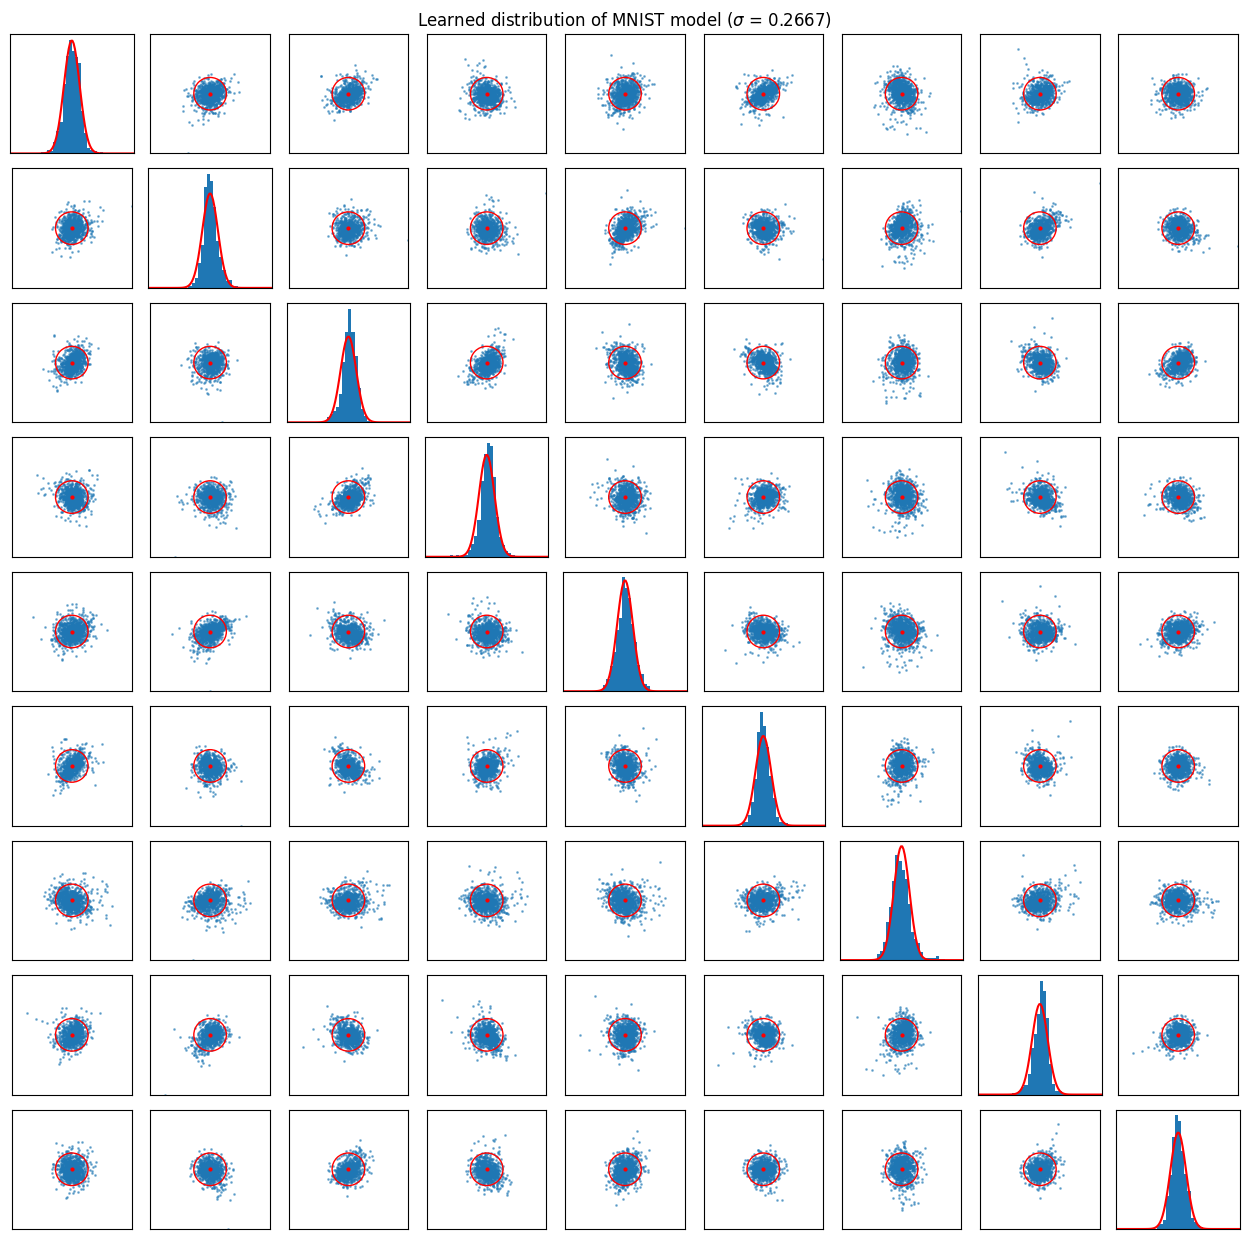

In [151]:
plot_learned_distribution(Z, f"Learned distribution of MNIST model ($\sigma$ = {sigma:.4f})", plotsize=1.4, axis_scale=2.1, alpha=0.5, sigma=sigma)

## Sampling

In [139]:
ncols = 10
nrows = 4
plotsize = 1.5

In [140]:
# sample 1's
# _y = torch.tensor([8]).expand(ncols * nrows)

# sample every kind of number several times
_y = torch.arange(10).repeat(nrows)
_y

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

In [152]:
# manually specify the standard deviation for the samples
Z_hat = torch.normal(0, sigma, size=(ncols * nrows, 9), device=DEVICE)
with torch.no_grad():
    X_hat = sv_maxpool.backward(Z_hat, y).view(nrows, ncols, 28, 28).cpu()

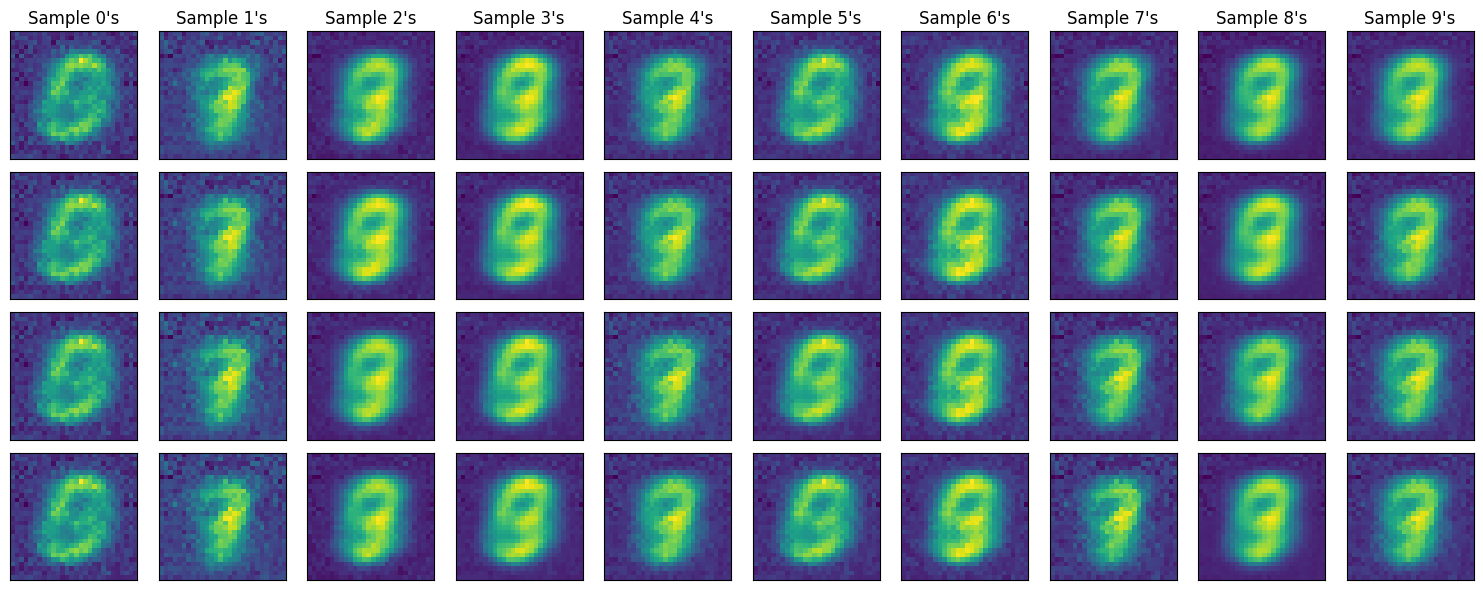

In [153]:
fig, ax = plt.subplots(nrows, ncols, figsize=(plotsize * ncols, plotsize * nrows))

for j in range(ncols):
    ax[0, j].set_title(f"Sample {j}'s")
    for i in range(nrows):
        _ax = ax[i, j]
        _ax.imshow(X_hat[i, j])
        _ax.set_xticks([])
        _ax.set_yticks([])

plt.tight_layout()
plt.show()

## Check that it outputs data in the correct interval

In [143]:
X_hist, bins = np.histogram(X_hat.flatten(), bins=30, density=True)

In [144]:
bins_centered = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

x_05, x_95 = X_hat.quantile(torch.tensor([0.005, 0.995]).cpu())

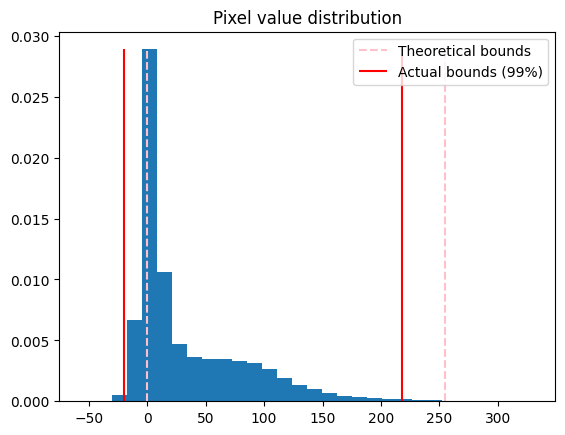

In [145]:
plt.bar(bins_centered, X_hist, bin_width)
plt.vlines([0, 255], 0, X_hist.max(), color='pink', linestyles='--', label='Theoretical bounds')
plt.vlines([x_05, x_95], 0, X_hist.max(), color='red', label='Actual bounds (99%)')

plt.legend()
plt.title("Pixel value distribution")
plt.show()

# MaxPoolingLayer development (kept for potential use in report)

In [ ]:
stride = 3
k = torch.distributions.categorical.Categorical(torch.tensor([1/stride**2] * stride**2))

In [ ]:
X = torch.rand((5, 2, 2))

In [ ]:
X

In [ ]:
i_x = k.sample((5, 2, 2))
i_x

In [ ]:
j = i_x.repeat_interleave(3, dim=2).repeat_interleave(3, dim=1)
j

In [ ]:
m = torch.arange(stride**2).reshape(stride, stride).repeat(2, 2)
m

In [ ]:
mask = (m == j)

In [ ]:
mask

In [ ]:
distr = torch.distributions.half_normal.HalfNormal(1)

In [ ]:
noise = distr.sample((5, 6, 6))

In [ ]:
noise[mask] = 0

In [ ]:
Y

In [ ]:
i_x

In [ ]:
Y.repeat_interleave(stride, dim=1).repeat_interleave(stride, dim=2)# - noise

In [ ]:
noise